In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [2]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=ETH&tsym=USD&limit=2000')
df = pd.DataFrame(json.loads(res.content)['Data'])
df = df.set_index('time')
df.index = pd.to_datetime(df.index, unit='s')
target_col='close'

In [3]:
df

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2016-05-02,10.46,8.635,8.819,3648152.10,3.702697e+07,10.150,multiply,BTC
2016-05-03,10.34,9.258,10.150,1952044.73,1.809752e+07,9.271,multiply,BTC
2016-05-04,10.02,9.103,9.271,1726008.21,1.616624e+07,9.366,multiply,BTC
2016-05-05,10.13,9.248,9.366,1646018.19,1.618917e+07,9.835,multiply,BTC
2016-05-06,10.26,8.952,9.835,2004919.41,1.851975e+07,9.237,multiply,BTC
...,...,...,...,...,...,...,...,...
2021-10-19,3888.54,3733.600,3746.140,291414.08,1.110236e+09,3877.450,direct,
2021-10-20,4168.74,3829.950,3877.450,427521.45,1.719887e+09,4162.490,direct,
2021-10-21,4373.21,4015.240,4162.490,585122.78,2.439960e+09,4062.760,direct,


In [4]:
df = df.drop(['conversionType','conversionSymbol'], axis=1)
df

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2016-05-02,10.46,8.635,8.819,3648152.10,3.702697e+07,10.150
2016-05-03,10.34,9.258,10.150,1952044.73,1.809752e+07,9.271
2016-05-04,10.02,9.103,9.271,1726008.21,1.616624e+07,9.366
2016-05-05,10.13,9.248,9.366,1646018.19,1.618917e+07,9.835
2016-05-06,10.26,8.952,9.835,2004919.41,1.851975e+07,9.237
...,...,...,...,...,...,...
2021-10-19,3888.54,3733.600,3746.140,291414.08,1.110236e+09,3877.450
2021-10-20,4168.74,3829.950,3877.450,427521.45,1.719887e+09,4162.490
2021-10-21,4373.21,4015.240,4162.490,585122.78,2.439960e+09,4062.760


In [5]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [7]:

def train_test_split(df, test_size=0.4):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [8]:
train, test = train_test_split(df,test_size=0.4)

In [9]:
np.array(train)
np.array(test)

array([[1.91560000e+02, 1.82650000e+02, 1.88130000e+02, 2.61407868e+06,
        4.84514498e+08, 1.85350000e+02],
       [1.86530000e+02, 1.81830000e+02, 1.85350000e+02, 1.97856954e+06,
        3.67239958e+08, 1.85610000e+02],
       [1.96100000e+02, 1.86800000e+02, 1.85610000e+02, 1.99709219e+06,
        3.88939845e+08, 1.94750000e+02],
       ...,
       [4.37321000e+03, 4.01524000e+03, 4.16249000e+03, 5.85122780e+05,
        2.43995984e+09, 4.06276000e+03],
       [4.16819000e+03, 3.89238000e+03, 4.06276000e+03, 3.65507010e+05,
        1.47477458e+09, 3.97195000e+03],
       [4.05433000e+03, 3.93793000e+03, 3.97195000e+03, 9.36572700e+04,
        3.75595412e+08, 4.02288000e+03]])

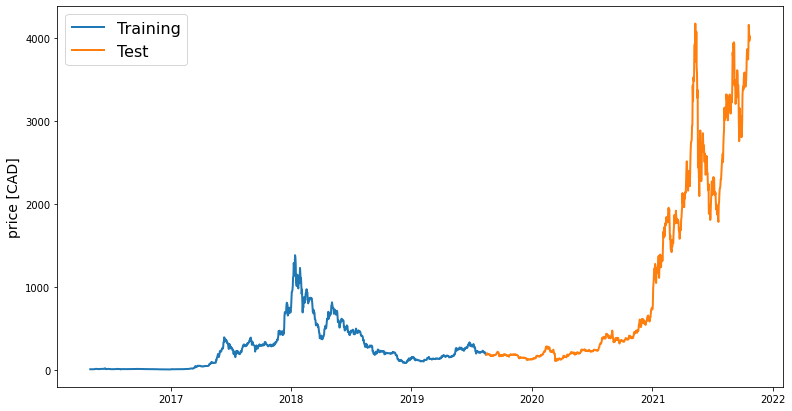

In [10]:
line_plot(train[target_col], test[target_col], 'Training', 'Test', title='')

In [11]:
print(train)
print(test)

              high      low     open  volumefrom      volumeto    close
time                                                                   
2016-05-02   10.46    8.635    8.819  3648152.10  3.702697e+07   10.150
2016-05-03   10.34    9.258   10.150  1952044.73  1.809752e+07    9.271
2016-05-04   10.02    9.103    9.271  1726008.21  1.616624e+07    9.366
2016-05-05   10.13    9.248    9.366  1646018.19  1.618917e+07    9.835
2016-05-06   10.26    8.952    9.835  2004919.41  1.851975e+07    9.237
...            ...      ...      ...         ...           ...      ...
2019-08-11  219.20  210.650  206.000  2107135.75  4.555594e+08  216.200
2019-08-12  213.51  210.670  216.200  1612897.03  3.408863e+08  211.350
2019-08-13  209.50  200.040  211.350  2018275.26  4.212996e+08  208.740
2019-08-14  198.43  182.180  208.740  2828543.26  5.275031e+08  186.490
2019-08-15  194.11  185.350  186.490  2833953.91  5.331526e+08  188.130

[1201 rows x 6 columns]
               high      low     open  

In [12]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [13]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [14]:
def prepare_data(df, target_col, window_len=5, zero_base=True, test_size=0.4):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [41]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [42]:
np.random.seed(42)
window_len = 5
test_size = 0.4
zero_base = True
lstm_neurons = 100
epochs = 40
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [43]:
train, test, X_train, X_test, y_train, y_test = prepare_data(df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [37]:
#Early stopping using callbacks
from keras.callbacks import EarlyStopping
es = EarlyStopping(mode='min',verbose=1,patience=4)

In [44]:
model = build_lstm_model( X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit( X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.3, validation_data=(X_test,y_test), verbose=1, shuffle=True, callbacks=[es])

Epoch 1/40
27/27 [==============================] - 2s 21ms/step - loss: 0.0193 - val_loss: 0.0051
Epoch 2/40
27/27 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.0044
Epoch 3/40
27/27 [==============================] - 0s 7ms/step - loss: 0.0097 - val_loss: 0.0042
Epoch 4/40
27/27 [==============================] - 0s 7ms/step - loss: 0.0090 - val_loss: 0.0038
Epoch 5/40
27/27 [==============================] - 0s 7ms/step - loss: 0.0087 - val_loss: 0.0036
Epoch 6/40
27/27 [==============================] - 0s 7ms/step - loss: 0.0077 - val_loss: 0.0035
Epoch 7/40
27/27 [==============================] - 0s 8ms/step - loss: 0.0072 - val_loss: 0.0034
Epoch 8/40
27/27 [==============================] - 0s 7ms/step - loss: 0.0067 - val_loss: 0.0033
Epoch 9/40
27/27 [==============================] - 0s 7ms/step - loss: 0.0067 - val_loss: 0.0032
Epoch 10/40
27/27 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0032
Epoch 11/40
27/27 

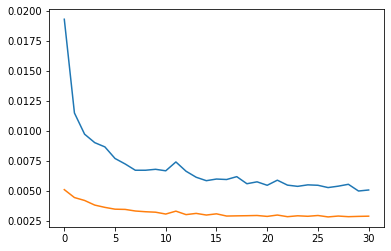

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [46]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.03785078487077672

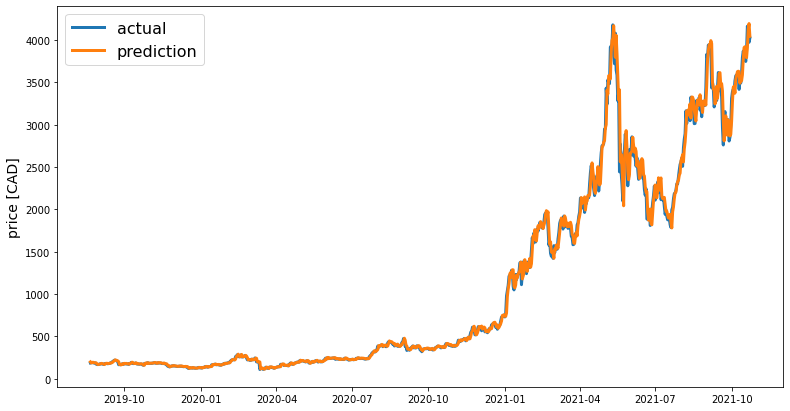

In [47]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [48]:
model.save('ETHmodel.hdf5')